## m1 popularity: PCA reduction
The analysis follows the following steps:

1. Preprocessing
2. Exploration of PCA reduction, with simple regression (subsets)
3. Given a reduction, experiment with ridge, elastic net, polynomial regression, k-neighbors, suport vector regression

Evaluation: https://vitalflux.com/interpreting-f-statistics-in-linear-regression-formula-examples

### Setup

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from scipy import stats 

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

sns.set_theme()
# Show plots
viz = True

In [2]:
# Load FOLD f2
df_train = pd.read_csv('data/fold/f2_train.csv',  parse_dates=['release'])
df_train = df_train.drop(columns=['release'])
df_test = pd.read_csv('data/fold/f2_test.csv',  parse_dates=['release'])
df_test = df_test.drop(columns=['release'])

In [3]:
class Feats():
    """
    Each feature has a first name, optionally a second name, a statistic and a number.
    This class allows to group feautures according to these aspects or combinations of these aspects.
    Each method produces a list of feature names or a list of lists of feature names.
    """

    def __init__(self, csv):
        self.fts = pd.read_csv(csv, dtype={'n':"string"})
        self.fts = self.fts.fillna('')

    def format(self, select):
        return select.apply(lambda x: '_'.join(x).replace('__', '_'), axis=1).tolist()

    def all(self):
        select = self.fts.copy()
        return self.format(select)

    def first(self):
        select = self.fts.copy()
        select = select.loc[select['n']=='01']
        return self.format(select)

    def chroma(self):
        select = self.fts.copy()
        select = select.loc[select['name1']=='chroma']
        return self.format(select)

    def mfcc(self):
        select = self.fts.copy()
        select = select.loc[select['name1']=='mfcc']
        return self.format(select)

    def tonnetz(self):
        select = self.fts.copy()
        select = select.loc[select['name1']=='tonnetz']
        return self.format(select)

    def min(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='min']
        return self.format(select)
    
    def max(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='max']
        return self.format(select)

    def median(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='median']
        return self.format(select)

    def mean(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='mean']
        return self.format(select)
    
    def std(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='std']
        return self.format(select)

    def skew(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='skew']
        return self.format(select)

    def kurtosis(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='kurtosis']
        return self.format(select)

    def per_nns(self):
        """
        List of lists per name1, name2, stat, per name1, name2.
        """
        select = self.fts.copy()
        select = [[self.format(grp2) for idx2, grp2 in grp.groupby(by=['stat'], sort=False)] for idx, grp in select.groupby(by=['name1', 'name2'])]
        return select
    
    def per_sn(self):
        """
        List of lists per stat, n. 
        """
        select = self.fts.copy()
        select = [[self.format(grp2) for idx2, grp2 in grp.groupby(by=['n'], sort=False)] for idx, grp in select.groupby(by=['stat'], sort=False)]
        return select

fts = Feats('features.csv')

#### Preprocessing

Train set: Dropped 0 NA entries and 1 zero entries of 68207, 68206 entries left.
Test set: Dropped 0 NA entries and 0 zero entries of 17052, 17052 entries left.

Scaled train X:
	mean: [-2.6043996707038242e-18, -5.208799341407649e-19, -3.125279604844589e-19, -9.375838814533767e-19, -1.5626398024222946e-18]...
	std: [1.0000073308139772, 1.000007330813977, 1.0000073308139772, 1.000007330813977, 1.0000073308139767]...
Scaled test X:
	mean: [-0.0063121717213264605, -0.005860147616092397, -0.00552303651490449, -0.005225488820206631, -0.000896847224604329]...
	std: [0.2395733624856694, 0.20176030900050407, 0.3595940728133728, 0.30697621016483573, 1.052623341043257]...


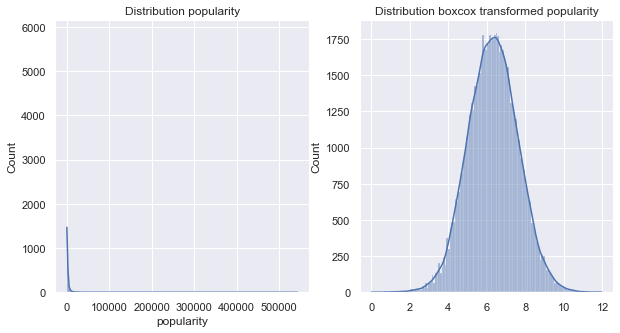

In [4]:
# Drop NA and zero values train
n_orig = df_train.shape[0]
n_na = df_train['popularity'].isna().sum()
df_train = df_train.dropna(subset=['popularity'])
n_zero =df_train.loc[df_train['popularity']==0].shape[0]
df_train = df_train.loc[df_train['popularity']>0]
print(f'Train set: Dropped {n_na} NA entries and {n_zero} zero entries of {n_orig}, {df_train.shape[0]} entries left.')

# Drop NA and zero values test
n_orig = df_test.shape[0]
n_na = df_test['popularity'].isna().sum()
df_test = df_test.dropna(subset=['popularity'])
n_zero =df_test.loc[df_test['popularity']==0].shape[0]
df_test = df_test.loc[df_test['popularity']>0]
print(f'Test set: Dropped {n_na} NA entries and {n_zero} zero entries of {n_orig}, {df_test.shape[0]} entries left.')

# Transform y train and test
y_train_before = df_train['popularity']
y_train = stats.boxcox(y_train_before)[0]
y_test_before = df_test['popularity']
y_test = stats.boxcox(y_test_before)[0]

if viz:
    fig, axs = plt.subplots(ncols=2, figsize=(10,5))
    ax1 = sns.histplot(x=y_train_before, kde=True, ax=axs[0])
    ax1.set(title="Distribution popularity")
    ax2 = sns.histplot(x=y_train, kde=True, ax=axs[1])
    ax2.set(title="Distribution boxcox transformed popularity")
    fig;

# Scale X train and test
X_train = df_train.drop(columns=['popularity'])
X_test = df_test.drop(columns=['popularity'])
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=fts.all())
X_test = pd.DataFrame(X_test, columns=fts.all())
print('')
print(f'Scaled train X:\n\tmean: {X_train.mean().tolist()[:5]}...\n\tstd: {X_train.std().tolist()[:5]}...')
print(f'Scaled test X:\n\tmean: {X_test.mean().tolist()[:5]}...\n\tstd: {X_test.std().tolist()[:5]}...')

### Benchmark

In [75]:
model = LinearRegression().fit(X_train, y_train)
score_bm = model.score(X_train, y_train)
print(f'Benchmark: Train R2 for all features: {score_bm:.3f}')

Benchmark: Train R2 for all features: 0.139


### 1. PCA reduction

In [150]:
fts_sets = {'all':fts.all(), 'first':fts.first(), 'mean':fts.mean(), 'kurtosis':fts.kurtosis(), 'chroma':fts.chroma(), 'mfcc':fts.mfcc()}
n_components = {'2':2, '10':10, '25':25, '50':50, '75':70, '100':100, '250':250, '518':518}

scores = {}
components = {}
for fts_name, fts_set in fts_sets.items():
    scores[fts_name] = {}
    for n_name, n in n_components.items():
        X_train_fts = X_train[fts_set]
        if n > X_train_fts.shape[1]:
            scores[fts_name][n_name]= np.nan
        else:
            pca = PCA(n_components=n).fit(X_train_fts)
            X_train_components = pca.transform(X_train_fts)
            model = LinearRegression().fit(X_train_components, y_train)
            r2 = round(model.score(X_train_components, y_train), 6)
            scores[fts_name][n_name]= r2
        if n == 2:
            components[fts_name] = X_train_components

In [151]:
# Keeping all features and no dim reduction results in the highest R2

print(f'Benchmark: train R2 for all features: {score_bm:.6f}')
print(f'--------------------------------------------------')
print(f'Train R2 for featset, n_components')
df_scores = pd.DataFrame.from_dict(scores, orient='index')
df_scores.style\
    .highlight_max(color='lightgreen', axis=1)\
    .highlight_max(color='green', axis=None)\
    .highlight_min(color='tomato', axis=1)\
    .highlight_min(color='red', axis=None)\
        

Benchmark: train R2 for all features: 0.138532
--------------------------------------------------
Train R2 for featset, n_components


,2,10,25,50,75,100,250,518
all,0.022416,0.041461,0.069319,0.088041,0.094011,0.100295,0.118657,0.138532
first,0.017164,0.027814,0.039128,0.051841,0.066497,nan,nan,nan
mean,0.024402,0.044404,0.073913,0.081020,0.082886,nan,nan,nan
kurtosis,0.028690,0.046430,0.056410,0.073258,0.076045,nan,nan,nan
chroma,0.021197,0.035720,0.042992,0.051757,0.052677,0.056492,0.075300,nan
mfcc,0.004905,0.024530,0.049466,0.055579,0.057286,0.060993,nan,nan


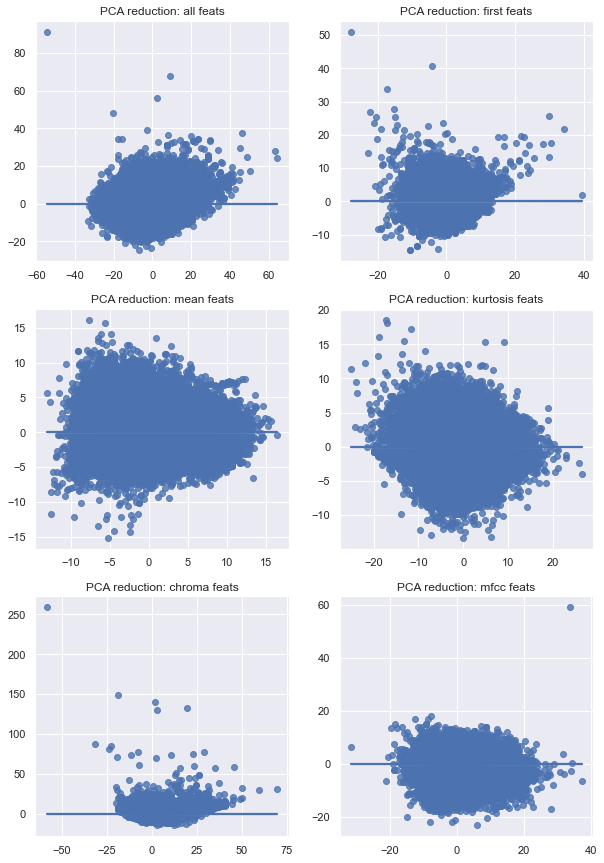

In [139]:
# These plots show that the 2 components are perpendicular, so PCA has done its job

if viz:
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(2*5, 3*5))
    i = 0
    for row in range(3):
        for col in range(2):
            featset = list(components.keys())[i]
            cs = components[featset].T
            ax = sns.regplot(x=cs[0], y=cs[1], order=1, ax=axs[row][col]);
            ax.set(title=f'PCA reduction: {featset} feats')
            i += 1
    fig;

### 2. Models

In [5]:
scores = {}

In [6]:
name = 'linear_regression'

X_train_fts = X_train[fts.all()]
X_test_fts = X_test[fts.all()]

model = LinearRegression().fit(X_train_fts, y_train)
y_pred = model.predict(X_test_fts)

scores[name] = {
    'R2_train': round(model.score(X_train_fts, y_train), 6),
    'R2_test': round(metrics.r2_score(y_test, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test, y_pred), 6),
}

In [7]:
name = 'elastic_net'

X_train_fts = X_train[fts.all()]
X_test_fts = X_test[fts.all()]

model = ElasticNet().fit(X_train_fts, y_train)
y_pred = model.predict(X_test_fts)

scores[name] = {
    'R2_train': round(model.score(X_train_fts, y_train), 6),
    'R2_test': round(metrics.r2_score(y_test, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test, y_pred), 6),
}

In [8]:
name = 'poly_linear_regression_mean_fts'

X_train_fts = X_train[fts.mean()]
X_test_fts = X_test[fts.mean()]
poly = PolynomialFeatures(2)
X_train_fts = poly.fit_transform(X_train_fts)
X_test_fts = poly.fit_transform(X_test_fts)

model = LinearRegression().fit(X_train_fts, y_train)
y_pred = model.predict(X_test_fts)

scores[name] = {
    'R2_train': round(model.score(X_train_fts, y_train), 6),
    'R2_test': round(metrics.r2_score(y_test, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test, y_pred), 6),
}

In [ ]:
# # https://scikit-learn.org/stable/modules/kernel_ridge.html

# from sklearn.kernel_ridge import KernelRidge

# name = 'kernel_ridge'

# X_train_fts = X_train[fts.all()]
# X_test_fts = X_test[fts.all()]

# model = KernelRidge().fit(X_train_fts, y_train)
# y_pred = model.predict(X_test_fts)

# scores[name] = {
#     'R2_train': round(model.score(X_train_fts, y_train), 6),
#     'R2_test': round(metrics.r2_score(y_test, y_pred), 6),
#     'MSE_test': round(metrics.mean_squared_error(y_test, y_pred), 6),
#     'MAE_test': round(metrics.mean_absolute_error(y_test, y_pred), 6),
# }

In [11]:
name = 'svr_10%_sub'

X_train_fts = X_train[fts.all()]
X_test_fts = X_test[fts.all()]
idx = X_train_fts.sample(frac=0.1).index
X_train_fts_sub = X_train_fts.iloc[idx]
y_train_sub = y_train[idx]

model = SVR().fit(X_train_fts_sub, y_train_sub)
y_pred = model.predict(X_test_fts)

scores[name] = {
    'R2_train': round(model.score(X_train_fts_sub, y_train_sub), 6),
    'R2_test': round(metrics.r2_score(y_test, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test, y_pred), 6),
}

In [12]:
name = 'k-neighbors'

X_train_fts = X_train[fts.all()]
X_test_fts = X_test[fts.all()]

model = KNeighborsRegressor().fit(X_train_fts, y_train)
y_pred = model.predict(X_test_fts)

scores[name] = {
    'R2_train': round(model.score(X_train_fts, y_train), 6),
    'R2_test': round(metrics.r2_score(y_test, y_pred), 6),
    'MSE_test': round(metrics.mean_squared_error(y_test, y_pred), 6),
    'MAE_test': round(metrics.mean_absolute_error(y_test, y_pred), 6),
}

In [15]:
df_scores = pd.DataFrame.from_dict(scores, orient='index')
df_scores.style\
    .highlight_max(color='green', axis=0)\
    .highlight_min(color='red', axis=0)

,R2_train,R2_test,MSE_test,MAE_test
linear_regression,0.138532,0.116957,1.487584,0.961749
elastic_net,0.000000,-0.000003,1.684617,1.031097
poly_linear_regression_mean_fts,0.171661,0.080109,1.549659,0.981359
svr_10%_sub,0.476400,0.113713,1.493049,0.967746
k-neighbors,0.387257,0.067183,1.571434,0.980211
